##Feature Extraction
    The following code will extract 6 characteristic of sunspots from images with 1 or more active regions

In [1]:
import astropy
from astropy.io import fits
from math import pi, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter, show
from time import time
import numpy as np
import pandas as pd
import os
from Cylindrical_Map_Transformation import get_header_params_MDI, map_disk_cylindric, get_header_params_HMI
from collections import Counter,defaultdict
import astropy.convolution
from astropy.convolution import convolve_fft, convolve
%matplotlib inline

In [2]:
def preprocess_image(hdu_object):
    # upload data to dataframe in order to replace nans with zeros
    df = pd.DataFrame(hdu_object.data)
    df.fillna(value=0,inplace=True)
    clean_data = df.values
    
    # choice appropriate method base on file type
    if hdu.header["INSTRUME"] == "MDI":
        params_method = get_header_params_MDI
    else:
        params_method = get_header_params_HMI
        
    # extract parameters from header  
    xCen,yCen,s0,nx,pixsize,p0,b0, r0  = params_method(hdu_object.header)
    
    # transform data into cylindrical equal area map
    return map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, clean_data)

In [3]:
path = "/Users/Alexander/NASA/NASA_Sample_Data/Images/"
filelist = []
for i, filename in enumerate(os.listdir(path)):
    if i != 0:
        filelist.append(filename)

In [4]:
'fd_M_96m_01d.3925.0000.fits'.rstrip(".fits").replace(".","_")

'fd_M_96m_01d_3925_0000'

In [5]:
filelist[0:4]

['fd_M_96m_01d.3925.0000.fits',
 'fd_M_96m_01d.3925.0001.fits',
 'fd_M_96m_01d.3925.0002.fits',
 'fd_M_96m_01d.3925.0013.fits']

In [6]:
#hdulist = fits.open("/Users/Alexander/NASA/NASA_Sample_Data/HMI.m2010.12.01_00.00.00.fits")

In [7]:
hdulist = fits.open(path + filelist[0])

In [8]:
filelist[0]

'fd_M_96m_01d.3925.0000.fits'

In [9]:
# refer to hud number 0 
hdu = hdulist[0]

In [10]:
hdu.header

SIMPLE  =                    T / file conforms with FITS standard; SOI V6R1B0   
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
COMMENT Data from the Solar Oscillations Investigation / Michelson Doppler      
COMMENT   Imager (SOI/MDI) on the Solar and Heliospheric Observatory (SOHO).    
COMMENT For information on data rights, keyword definitions, and up-to-date     
COMMENT   reports on known problems and data quality, see:                      
COMMENT   http://soi.stanford.edu/data.html                                     
HISTORY created by mdical Tue Oct  7 13:54:41 2003                              
HISTORY created by MDI_image_reconstructor Wed Oct  8 12:55:16 2003             
HISTORY An MDI magnetogram z

In [11]:
start = time()
clean_data = preprocess_image(hdu) 
end = time()
print "Elaspsed Time = {}".format(end - start)

Elaspsed Time = 21.5849440098


### MDI Images
    change std for gaussian kernel, will likely be 10x larger
    

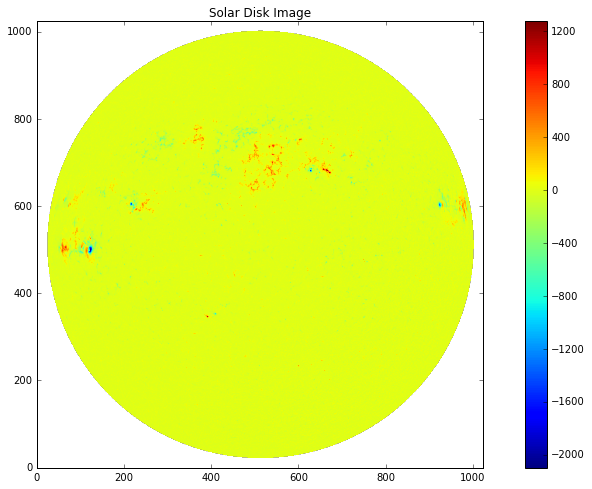

In [12]:
plt.figure(figsize = (15,8));
a1 = np.ma.masked_where(hdu.data == 0.0, hdu.data)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
# plt.xlim((280,380))
# plt.ylim((350,400))
plt.colorbar()

plt.show()

###Equal Area Cylindrical Map

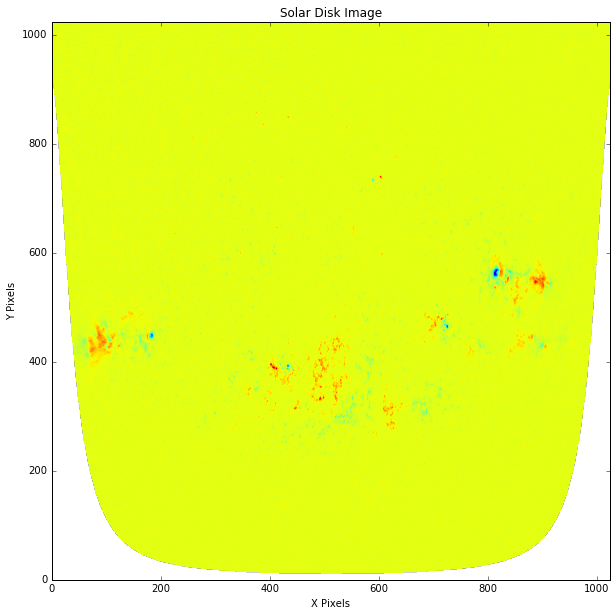

In [13]:
plt.figure(figsize = (10,10));
a1 = np.ma.masked_where(clean_data == 0.0, clean_data)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
# plt.xlim((380,420))
# plt.ylim((400,475))
#plt.colorbar()

plt.show()

##Cylindrical Mapping for HMI Data is problematic 

In [25]:
# plt.figure(figsize = (8,15));
# a1 = np.ma.masked_where(clean_data == 0.0, clean_data)
# plt.imshow(a1, origin='lower');
# plt.title("Solar Disk Image")
# plt.xlabel("X Pixels")
# plt.ylabel("Y Pixels")
# plt.xlim((350,500))
# plt.ylim((350,750))
# plt.colorbar()

# plt.show()

In [14]:
data_abs_diff = np.abs(clean_data)

In [15]:
k = 10 # for MDI images 
gauss = astropy.convolution.Gaussian2DKernel(stddev=k)

In [16]:
start = time()
smoothing = convolve_fft(data_abs_diff, gauss)
end = time()
print "Time Elapsed = {}".format(end - start)

Time Elapsed = 1.41578006744


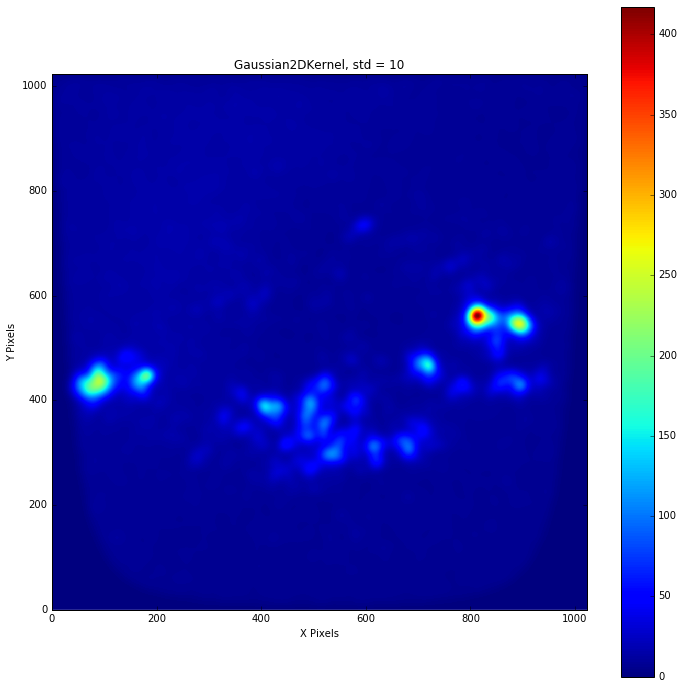

In [17]:
plt.figure(figsize = (12,12));
plt.imshow(smoothing, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel, std = 10")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
# plt.xlim((3800,4000))
# plt.ylim((0,475))
plt.colorbar()
plt.show()

In [18]:
k = 130 # <-- use this value, confirmed by David for MDI images
k_MDI = 700 # need different value for MDI data -- talk to David
smoothing[smoothing < k] = 0.
smoothing[smoothing >= k] = 1 

In [25]:
# filter original image with active region map 
test_diff = np.where(smoothing !=0.0 , clean_data, smoothing)

###Identify Distinct Active Regions

In [20]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [21]:
from time import time

##Experiment with peak_local_max methods for faster process time
    killed process at ~ 60 mins !!!!
    As the code stands, not a viable option!

In [26]:
# Now we want to separbate the two objects in image
# Generate the markers as local maxima of the distance to the background
# Exact euclidean distance transform
distance = ndi.distance_transform_edt(test_diff)

In [27]:
start = time()
# Find peaks in an image, and return them as coordinates or a boolean array
local_maxi = peak_local_max(distance, 
                            indices=False, 
                            footprint=np.ones((3, 3)),
                            labels=test_diff)
end = time()

print "Time Elapase = {:.3}".format(end - start)

Time Elapase = 1.84e+02


In [28]:
# return labels of peaks
markers = ndi.label(local_maxi)[0]

In [30]:
# Return a matrix labeled using the watershed segmentation algorithm
labels = watershed(-distance, markers, mask=test_diff)

(500, 620)

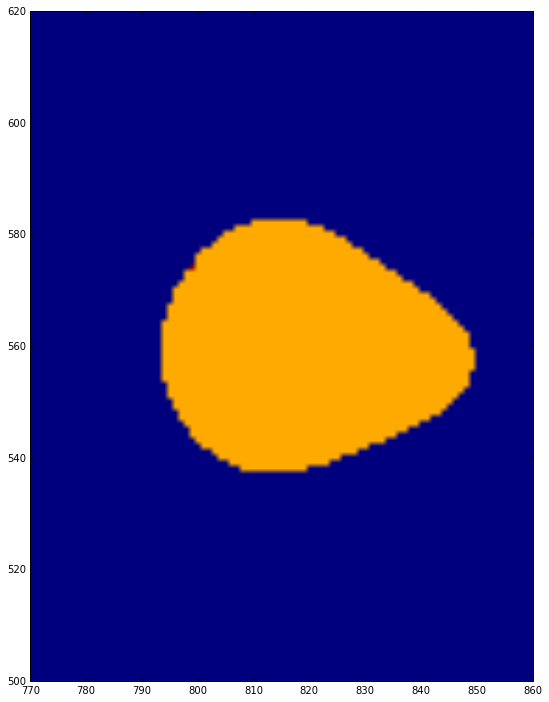

In [122]:
plt.figure(figsize = (12,12));
plt.imshow(labels,  origin='lower');
plt.xlim((770,860))
plt.ylim((500,620))

In [33]:
# 0
def identify_active_regions(labels): 
    '''INPUT: 2D array of labeld active regions
       OUTPUT: 
    '''
    count_ar = defaultdict(list)
    # sort the labels into dict 
    for row in labels:
        for elem in row:
            count_ar[elem].append(elem)
            
    # Need a pixel threshold for filtering pseudo-active regions (false positives)
    # let's try 100 pixels
    # label 0 is for the background 
    
    active_labels = []
    for key, val in count_ar.iteritems():
        # exclude false positive active regions and exclude zeroed-out background
        if Counter(val)[key] >= 100 and np.sum(val) > 1 :
            active_labels.append(key)
    return active_labels

In [34]:
# 1
def get_flux_from_active_regions(active_labels):
    '''INPUT: 2D array with each pixel labeled with the number of its corresponding active region
       OUTPUT: Dictionary, 
               keys indicate active region
               values are list flux values for each active region 
    '''
    active_regions_dict = defaultdict(list)
    for image_row, label_row in zip(test_diff, labels):  
        for image_col, label_col in zip(image_row, label_row):   
            if label_col in active_labels:
                active_regions_dict[label_col].append(image_col)
                
    return active_regions_dict

In [35]:
# 2 
def get_net_flux_along_dim(image_array):
    net_B_pos = 0
    net_B_neg = 0 
    for elem in image_array:
        if np.sign(elem) == 1:
            net_B_pos += elem
        else:
            net_B_neg += elem    
    return net_B_pos, net_B_neg

In [36]:
# 3
def get_net_flux(active_regions):
    '''INPUT: Dictionary
              keys indicate active region 
              values are a list of flux values for each active region
       OUTPUT: Dictionary
              keys indicate active region
              values are a tuple of net flux values for each polarity of each active region
    '''
    flux_dict = dict()
    for ar, blist in active_regions.iteritems():
        flux_dict[ar] = get_net_flux_along_dim(blist)
    return flux_dict

In [37]:
# 4
# list of x * B(x,y)  values for each active region

# Assuming there exist more than one active regions
def get_flux_along_dim(valid_labels, image, labels):
    '''
       Calculates  x * B(x,y) and  y * B(x,y) values for each active region
       INPUT: 
             valid_labels, list of non-pseudo active regions
             image, array of image data
             labels, array of all labels for 
       OUTPUT: Dictionary
              keys indicate active region
              values are a tuple of net flux values for each polarity of each active region
    '''
    B_pos_dict = defaultdict(list)
    B_neg_dict = defaultdict(list)
#     B_pos_y_dict = defaultdict(list)
#     B_neg_y_dict = defaultdict(list)
    for row in xrange(0, len(image)):
        for col in xrange(1, len(image)):
            
            if labels[row][col] in valid_labels:
                
                if np.sign(image[row][col]) == 1:
                    B_pos_dict[labels[row][col]].append(col * image[row][col])
                else:
                    B_neg_dict[labels[row][col]].append(col * image[row][col])
                                                                    
    return B_pos_dict, B_neg_dict

In [38]:
# 5
def get_dim_sum(dim_dict):
    '''
       Calculates  x * B(x,y) and  y * B(x,y) values for each active region
       INPUT: 
             valid_labels, list of non-pseudo active regions
             image, array of image data
             labels, array of all labels for 
       OUTPUT: Dictionary
              keys indicate active region
              values are a tuple of net flux values for each polarity of each active region
    '''
    result_dict = dict()
    for active_region, b_list in dim_dict.iteritems():
        result_dict[active_region] = np.sum(b_list)
    return result_dict  

In [111]:

def get_features(net_flux_active_regions, B_pos_x_sum, B_neg_x_sum, B_pos_y_sum, B_neg_y_sum):#, hdu, file_name):
    '''
       Calculates  centroid of each polarity in each active region 
       INPUT: 
             valid_labels: list of active regions
             Flux Fields: dictinary
             hdu: fits file reader object for a single image
       OUTPUT: Dictionary
              keys indicate active region
              values are  centroids of each polarity in each active region 
    '''

    results_dict = dict()
    bugs = []
    bugs_found = False
    feat_names = ["x_pos_ave",
                  "x_neg_ave",
                  "y_pos_ave", 
                  "y_neg_ave",
                  "pos_net_flux",
                  "neg_net_flux"]

    active_region_num = 1

    # get centroids for each active region in the image
    for label, net_flux in net_flux_active_regions.iteritems():
      features_dict = dict()
      # (CASE 3 ) check if One or More Active Regions in Image have netflux = zero
      if net_flux[0] == 0.0 or net_flux[1] == 0.0:
#           # assign a key:value pair of {0:(0,0)} indicating zero flux for this active region
#           results_dict[0] = (0,0)
#           error_type = "One or more flux for active region {} is zero.".format(active_region_num)
#           bugs.append((file_name, error_type))
#           bugs_found = True
            pass
          
      else:
          # get centroids
          x_pos_ave = truncate(B_pos_x_sum[label]/ net_flux[0])
          x_neg_ave = truncate(B_neg_x_sum[label]/ net_flux[1])
          y_pos_ave = truncate(B_pos_y_sum[label]/ net_flux[0])
          y_neg_ave = truncate(B_neg_y_sum[label]/ net_flux[1])

          feats = [x_pos_ave, 
                   x_neg_ave, 
                   y_pos_ave, 
                   y_neg_ave,
                   truncate(net_flux[0]),
                   truncate(net_flux[1])]

          # pair each feature name with feature values   
          for feat, name in zip(feats, feat_names):
              features_dict[name] = feat 

          # pair each active region number with it's list of features 
          results_dict[active_region_num] = features_dict

      active_region_num += 1


#     if bugs_found == True:
#       # write bugs to log file
#       log_path = "/Users/Alexander/NASA/Image_Log/"
#       file_ = file_name.rstrip(".fits").replace(".","_")
#       with open(log_path + file_ + ".pk", 'w') as file_path:
#         pickle.dump(net_flux,file_path)
    
    # get header parameters for the image
    params, param_names = get_header_parameters(hdu)
    for param, name, in zip(params, param_names):
        results_dict[name] = param

    return results_dict

In [76]:
ar_labels = identify_active_regions(labels)

In [77]:
ar_labels

[1, 2, 3, 4, 6, 8]

In [78]:
 # list of b_pos and b_neg values for each active region
active_region_flux = get_flux_from_active_regions(ar_labels)

In [79]:
active_region_flux.keys()

[1, 2, 3, 4, 6, 8]

In [80]:
# list of x * B(x,y)  values for each active region
B_pos_x_dict, B_neg_x_dict = get_flux_along_dim(ar_labels, test_diff, labels)

In [81]:
B_pos_x_dict.keys()

[1, 2, 3, 4, 6, 8]

In [82]:
# list of y * B(x,y) values for each active region
B_pos_y_dict, B_neg_y_dict = get_flux_along_dim(ar_labels, test_diff.T, labels.T)

In [83]:
# net pos and net flux for each active region
net_flux_active_regions = get_net_flux(active_region_flux)

In [84]:
net_flux_active_regions

{1: (220779.0, 0),
 2: (2516320.3621899388, -57276.734207767346),
 3: (116369.65723258113, -114687.36800635935),
 4: (21061.0, -76818.280238125779),
 6: (1594988.8035644502, -14762.44699865668),
 8: (607374.87574123451, -424459.11095772643)}

In [85]:
B_pos_x_sum =  get_dim_sum(B_pos_x_dict)
B_neg_x_sum =  get_dim_sum(B_neg_x_dict)
B_pos_y_sum =  get_dim_sum(B_pos_y_dict)
B_neg_y_sum =  get_dim_sum(B_neg_y_dict)

In [88]:
from sunspot_feature_extraction import get_header_parameters


In [125]:
# exclude false positive active regions
ar_labels = identify_active_regions(labels)
# list of b_pos and b_neg values for each active region
active_region_flux = get_flux_from_active_regions(ar_labels)
# list of x * B(x,y)  values for each active region
B_pos_x_dict, B_neg_x_dict = get_flux_along_dim(ar_labels, test_diff, labels)
# list of y * B(x,y) values for each active region
B_pos_y_dict, B_neg_y_dict = get_flux_along_dim(ar_labels, test_diff.T, labels.T)
# net pos and net flux for each active region
net_flux_active_regions = get_net_flux(active_region_flux)
#Calculates  x * B(x,y) and  y * B(x,y) values for each active region
B_pos_x_sum =  get_dim_sum(B_pos_x_dict)
B_neg_x_sum =  get_dim_sum(B_neg_x_dict)
B_pos_y_sum =  get_dim_sum(B_pos_y_dict)
B_neg_y_sum =  get_dim_sum(B_neg_y_dict)
feature_results = get_features(net_flux_active_regions, B_pos_x_sum, B_neg_x_sum, B_pos_y_sum, B_neg_y_sum)
feature_results

{2: {'neg_net_flux': -57276.73,
  'pos_net_flux': 2516320.36,
  'x_neg_ave': 84.18,
  'x_pos_ave': 85.88,
  'y_neg_ave': 434.97,
  'y_pos_ave': 433.35},
 3: {'neg_net_flux': -114687.36,
  'pos_net_flux': 116369.65,
  'x_neg_ave': 180.15,
  'x_pos_ave': 174.51,
  'y_neg_ave': 446.01,
  'y_pos_ave': 446.39},
 4: {'neg_net_flux': -76818.28,
  'pos_net_flux': 21061.0,
  'x_neg_ave': 720.38,
  'x_pos_ave': 713.13,
  'y_neg_ave': 466.64,
  'y_pos_ave': 475.01},
 5: {'neg_net_flux': -14762.44,
  'pos_net_flux': 1594988.8,
  'x_neg_ave': 904.46,
  'x_pos_ave': 892.0,
  'y_neg_ave': 541.52,
  'y_pos_ave': 547.41},
 6: {'neg_net_flux': -424459.11,
  'pos_net_flux': 607374.87,
  'x_neg_ave': 816.94,
  'x_pos_ave': 824.21,
  'y_neg_ave': 559.51,
  'y_pos_ave': 562.74},
 'car_long': 297.3335268426,
 'image_date': '2003 10 01',
 'image_time': '00:03:03',
 'image_type': 'MDI'}

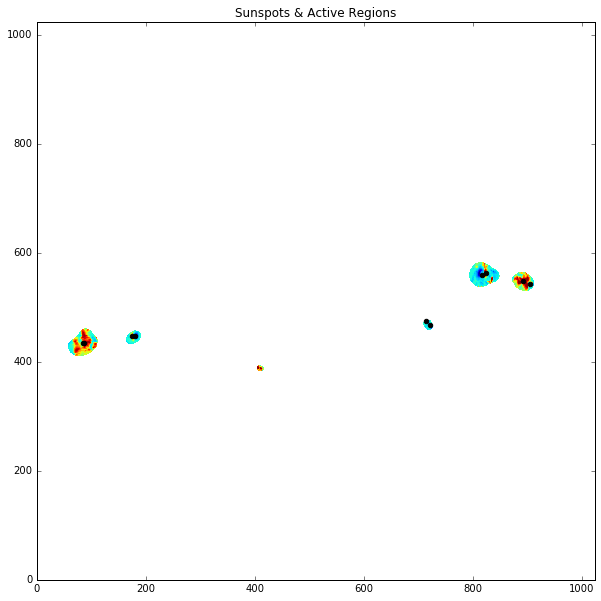

In [131]:
plt.figure(figsize = (10,10));
test_plot_diff  = np.ma.masked_where(test_diff== 0.0, test_diff )

for index in feature_results.keys():
    if isinstance(index, int):
        plt.scatter(feature_results[index]["x_pos_ave"],\
                    feature_results[index]["y_pos_ave"], c='k', marker ='o');
        plt.scatter(feature_results[index]["x_neg_ave"],\
                    feature_results[index]["y_neg_ave"], c='k', marker ='o');
    
plt.imshow(test_plot_diff, interpolation='none', origin='lower');
plt.title("Sunspots & Active Regions");
# plt.xlim([775,850])
# plt.ylim([500,600])
plt.show();

In [92]:
# original labels
# labels that dropted were either the zeroed-out background
# or false positive active regions
# FP AR are determined by the number of pixels in the region
#    IF an AR has less than 100 pixels, then it is considered a FP
ar_labels

[1, 2, 3, 4, 6, 8]

###Zero Active Regions in Image

###One Active region and Netflux = Zero

In [93]:
net_flux_active_regions

{1: (220779.0, 0),
 2: (2516320.3621899388, -57276.734207767346),
 3: (116369.65723258113, -114687.36800635935),
 4: (21061.0, -76818.280238125779),
 6: (1594988.8035644502, -14762.44699865668),
 8: (607374.87574123451, -424459.11095772643)}

In [131]:
{1: (0, 0)}, {1: (0, 3423)}, {1: (-3424, 0)}

({1: (0, 0)}, {1: (0, 3423)}, {1: (-3424, 0)})

In [138]:
single_ar_zero_netflux = {1: (0,2342)}

In [144]:
# check for single active region 
if sum(single_ar_zero_netflux) ==1:
    if single_ar_zero_netflux.values()[0][0] == 0 or single_ar_zero_netflux.values()[0][1] == 0:
        print "zero"
        # this is an entry in the log file
        # return hdu parameters and a key:value pair of 0:0 indicating zero active regions

zero


### N Active Regions and Netflux = Zero for M < N Active Regions 

In [145]:
def truncate(num):
    before_dec, after_dec = str(num).split('.')
    return float('.'.join((before_dec, after_dec[0:2])))


def get_header_parameters(hdu):
    image_date = hdu.header["DATE-OBS"].replace("/", " ")
    image_time = hdu.header["TIME-OBS"].rstrip(".").partition(".")[0]
    if hdu.header["INSTRUME"] == "MDI":
        # MDI
        car_long = hdu.header["OBS_L0"]
    else:
        # HMI 
        car_long = hdu.header["CRLN_OBS"]

    param_names = ["image_date", "image_time", "car_long"]
    params = [image_date, image_time, car_long]    
    return params, param_names

In [166]:
test = [(1,"939393")]

In [174]:
import pickle

ImportError: No module named Cpickle

In [178]:
pickle.loads?

In [176]:
log_path = "/Users/Alexander/NASA/Image_Log/"
with open(log_path + "test_file_name", 'w') as file_path:
    pickle.dump(test,file_path)

In [181]:
with open(log_path + "test_file_name", 'r') as file_path:
    print pickle.load(file_path)

[(1, '939393')]


In [151]:
def test():
    for i in range(10):
        if i % 2 == 0:
            break
        print "odd {}".format(i)

    print "now do somethng else in the function"

In [152]:
test()

now do somethng else in the function


##End of 4 Case Analysis

###Move image parameters into 

In [77]:
image_date = hdu.header["DATE-OBS"].replace("/", " ")
image_time =  hdu.header["TIME-OBS"].rstrip(".").partition(".")[0]
car_long = hdu.header["OBS_L0"]

In [78]:
params = [image_date, image_time, car_long]
param_names = ["image_date", "image_time", "car_long"]

In [79]:
for param, name, in zip(params, param_names):
    results[name] = param

In [123]:
import json

In [98]:
def get_image_active_region_centroids(features_dict):
	'''
	gets the longitude and latitude values of every active region in the image
	'''

	x_cents = []
	y_cents = []
	ar_cents = []
	for ar_num, ar_vals in features_dict.iteritems():
		if isinstance(ar_num, int) and ar_num > 0:
			x_cents.append(ar_vals['long_pos'])
			y_cents.append(ar_vals['lat_pos'])
			x_cents.append(ar_vals['long_neg'])
			y_cents.append(ar_vals['lat_neg'])
			# get active region centroid pairs for the labeling process
			x_cent = (ar_vals['long_pos'] + ar_vals['long_neg'])/2.
			y_cent = (ar_vals['lat_pos'] + ar_vals['lat_neg'])/2.
			ar_cents.append([x_cent,y_cent])
	return x_cents, y_cents, ar_cents


In [112]:
def extract_features(labels,image):
    # exclude false positive active regions
    ar_labels = identify_active_regions(labels)
    # list of b_pos and b_neg values for each active region
    active_region_flux = get_flux_from_active_regions(ar_labels)
    # list of x * B(x,y)  values for each active region
    B_pos_x_dict, B_neg_x_dict = get_flux_along_dim(ar_labels, image, labels)
    # list of y * B(x,y) values for each active region
    B_pos_y_dict, B_neg_y_dict = get_flux_along_dim(ar_labels, image.T, labels.T)
    # net pos and net flux for each active region
    net_flux_active_regions = get_net_flux(active_region_flux)
    #Calculates  x * B(x,y) and  y * B(x,y) values for each active region
    B_pos_x_sum =  get_dim_sum(B_pos_x_dict)
    B_neg_x_sum =  get_dim_sum(B_neg_x_dict)
    B_pos_y_sum =  get_dim_sum(B_pos_y_dict)
    B_neg_y_sum =  get_dim_sum(B_neg_y_dict)
    return get_features(net_flux_active_regions, B_pos_x_sum, B_neg_x_sum, B_pos_y_sum, B_neg_y_sum)

In [113]:
results = extract_features(labels,test_diff)

In [114]:
results.keys()

[2, 3, 4, 5, 6, 'image_type', 'image_time', 'car_long', 'image_date']